In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import lightgbm as lgb
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive

In [2]:
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab Notebooks/AIQuest/課題4'
!pwd

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/AIQuest/課題4
/content/drive/MyDrive/Colab Notebooks/AIQuest/課題4


In [ ]:
sales = pd.read_csv('sales_history.csv')
cats = pd.read_csv('item_categories.csv')
cat_names = pd.read_csv('category_names.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv', header=None)

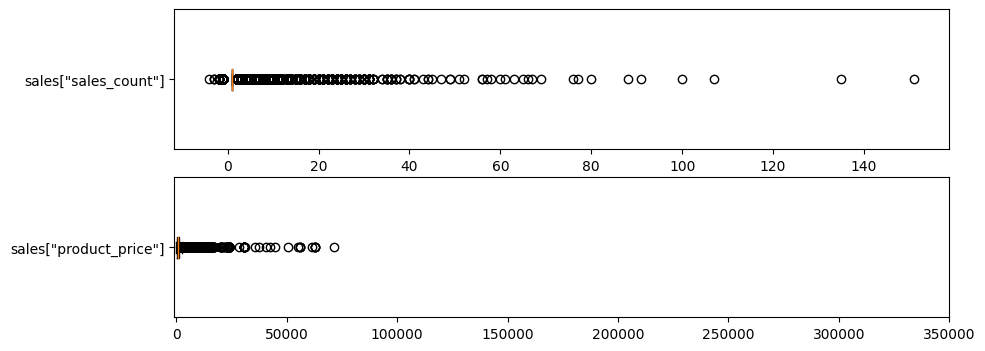

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(10,4))

plt.xlim(-300, 3000)
ax[0].boxplot((sales['売上個数']) , labels=['sales["sales_count"]'], vert=False)

plt.xlim(-1000, 350000)
ax[1].boxplot((sales['商品価格']) , labels=['sales["product_price"]'], vert=False)
plt.show()

In [ ]:
sales = sales[sales['売上個数']<120]

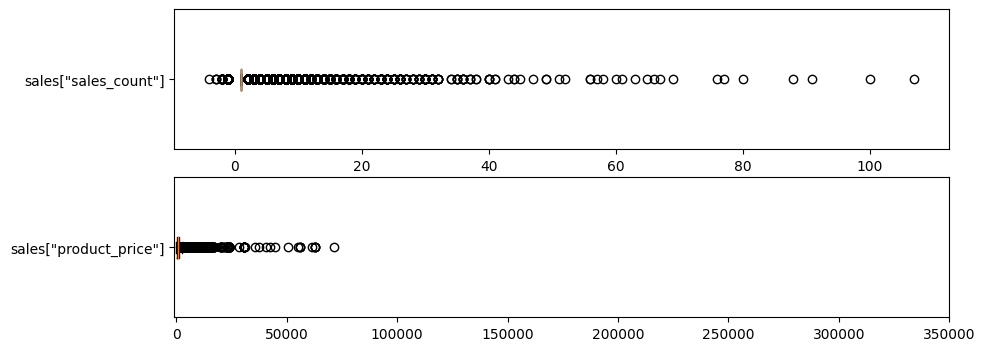

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(10,4))

plt.xlim(-300, 3000)
ax[0].boxplot((sales['売上個数']) , labels=['sales["sales_count"]'], vert=False)

plt.xlim(-1000, 350000)
ax[1].boxplot((sales['商品価格']) , labels=['sales["product_price"]'], vert=False)
plt.show()

In [ ]:
sales = pd.merge(sales, cats, on='商品ID', how='left')
sales = pd.merge(sales, cat_names, on='商品カテゴリID', how='left')

sales

,日付,店舗ID,商品ID,商品価格,売上個数,商品カテゴリID,商品カテゴリ名
0,2018-01-01,9,1000001,420,1.0,100,映画 - DVD
1,2018-01-01,6,1000001,420,1.0,100,映画 - DVD
2,2018-01-01,10,1000001,420,1.0,100,映画 - DVD
3,2018-01-01,0,1000017,250,1.0,100,映画 - DVD
4,2018-01-01,1,1000017,250,1.0,100,映画 - DVD
...,...,...,...,...,...,...,...
1119563,2019-10-31,8,3400006,2700,1.0,340,ゲーム周辺機器 - ゲーム機A
1119564,2019-10-31,7,3400009,1020,1.0,340,ゲーム周辺機器 - ゲーム機A
1119565,2019-10-31,7,3400012,510,1.0,340,ゲーム周辺機器 - ゲーム機A
1119566,2019-10-31,4,3500001,340,1.0,350,本 - オーディオブック_タイプB


In [ ]:
# 「日付」カラムの文字列から、「年」「月」の情報を抽出する
sales['年'] = sales['日付'].apply(lambda x: x.split('-')[0])
sales['月'] = sales['日付'].apply(lambda x: x.split('-')[1])
sales['年'] = sales['年'].astype(int)
sales['月'] = sales['月'].astype(int)

sales

,日付,店舗ID,商品ID,商品価格,売上個数,商品カテゴリID,商品カテゴリ名,年,月
0,2018-01-01,9,1000001,420,1.0,100,映画 - DVD,2018,1
1,2018-01-01,6,1000001,420,1.0,100,映画 - DVD,2018,1
2,2018-01-01,10,1000001,420,1.0,100,映画 - DVD,2018,1
3,2018-01-01,0,1000017,250,1.0,100,映画 - DVD,2018,1
4,2018-01-01,1,1000017,250,1.0,100,映画 - DVD,2018,1
...,...,...,...,...,...,...,...,...,...
1119563,2019-10-31,8,3400006,2700,1.0,340,ゲーム周辺機器 - ゲーム機A,2019,10
1119564,2019-10-31,7,3400009,1020,1.0,340,ゲーム周辺機器 - ゲーム機A,2019,10
1119565,2019-10-31,7,3400012,510,1.0,340,ゲーム周辺機器 - ゲーム機A,2019,10
1119566,2019-10-31,4,3500001,340,1.0,350,本 - オーディオブック_タイプB,2019,10


In [ ]:
gp_month = sales.groupby(['年', '月', '商品ID', '店舗ID']).agg({'売上個数': np.sum}).reset_index()
gp_month

,年,月,商品ID,店舗ID,売上個数
0,2018,1,1000001,0,6.0
1,2018,1,1000001,1,2.0
2,2018,1,1000001,2,1.0
3,2018,1,1000001,3,2.0
4,2018,1,1000001,5,2.0
...,...,...,...,...,...
495129,2019,10,3500070,16,1.0
495130,2019,10,3500071,13,1.0
495131,2019,10,3500072,2,1.0
495132,2019,10,3500072,16,1.0


In [ ]:
gp = gp_month.groupby(['商品ID', '店舗ID']).agg({'売上個数': np.sum}).reset_index()
gp

,商品ID,店舗ID,売上個数
0,1000001,0,30.0
1,1000001,1,9.0
2,1000001,2,27.0
3,1000001,3,95.0
4,1000001,4,114.0
...,...,...,...
107110,3500070,16,1.0
107111,3500071,13,1.0
107112,3500072,2,1.0
107113,3500072,16,1.0


In [ ]:
g = gp.groupby(['商品ID', '店舗ID']).agg({'売上個数': np.average}).reset_index()


,商品ID,店舗ID,売上個数
0,1000001,0,30.0
1,1000001,1,9.0
2,1000001,2,27.0
3,1000001,3,95.0
4,1000001,4,114.0
...,...,...,...
107110,3500070,16,1.0
107111,3500071,13,1.0
107112,3500072,2,1.0
107113,3500072,16,1.0


In [ ]:
g.to_csv('a.csv', index=False, header=False)

In [ ]:
gtmp = g[:len(test)]
gtmp

,商品ID,店舗ID,売上個数
0,1000001,0,30.0
1,1000001,1,9.0
2,1000001,2,27.0
3,1000001,3,95.0
4,1000001,4,114.0
...,...,...,...
3055,1000195,15,6.0
3056,1000195,16,1.0
3057,1000195,17,4.0
3058,1000196,0,8.0


In [ ]:
test['売上予測'] = 0

In [ ]:
test

,index,商品ID,店舗ID,年,月,売上予測
0,0,1000001,0,2019,12,0
1,1,1000001,1,2019,12,0
2,2,1000001,2,2019,12,0
3,3,1000001,3,2019,12,0
4,4,1000001,4,2019,12,0
...,...,...,...,...,...,...
3055,3055,3500001,13,2019,12,0
3056,3056,3500001,14,2019,12,0
3057,3057,3500001,15,2019,12,0
3058,3058,3500001,16,2019,12,0


In [ ]:
for i in range(len(test)):
    print(i)
    for j in range(len(gtmp)):
        if (test['商品ID'][i] == gtmp['商品ID'][j]) & (test['店舗ID'][i] == gtmp['店舗ID'][j]):
            test['売上予測'][i] = gtmp['売上個数'][j]

In [ ]:
a = test
a

,index,商品ID,店舗ID,年,月,売上予測
0,0,1000001,0,2019,12,30
1,1,1000001,1,2019,12,9
2,2,1000001,2,2019,12,27
3,3,1000001,3,2019,12,95
4,4,1000001,4,2019,12,114
...,...,...,...,...,...,...
3055,3055,3500001,13,2019,12,0
3056,3056,3500001,14,2019,12,0
3057,3057,3500001,15,2019,12,0
3058,3058,3500001,16,2019,12,0


In [ ]:
a['売上予測'] = a['売上予測'] / 31

In [ ]:
a

,index,商品ID,店舗ID,年,月,売上予測
0,0,1000001,0,2019,12,0.967742
1,1,1000001,1,2019,12,0.290323
2,2,1000001,2,2019,12,0.870968
3,3,1000001,3,2019,12,3.064516
4,4,1000001,4,2019,12,3.677419
...,...,...,...,...,...,...
3055,3055,3500001,13,2019,12,0.000000
3056,3056,3500001,14,2019,12,0.000000
3057,3057,3500001,15,2019,12,0.000000
3058,3058,3500001,16,2019,12,0.000000


In [ ]:
sub.iloc[:, -1] = a['売上予測']
sub.to_csv('my_submission3.csv', index=False, header=False)

In [ ]:
train = sales.drop(['日付', '商品カテゴリID', '商品カテゴリ名', '商品価格'], axis=1)
train

,店舗ID,商品ID,売上個数,年,月
0,9,1000001,1.0,2018,1
1,6,1000001,1.0,2018,1
2,10,1000001,1.0,2018,1
3,0,1000017,1.0,2018,1
4,1,1000017,1.0,2018,1
...,...,...,...,...,...
1119563,8,3400006,1.0,2019,10
1119564,7,3400009,1.0,2019,10
1119565,7,3400012,1.0,2019,10
1119566,4,3500001,1.0,2019,10


In [ ]:
test['年'] = 2019
test['月'] = 12
test

,index,商品ID,店舗ID,年,月
0,0,1000001,0,2019,12
1,1,1000001,1,2019,12
2,2,1000001,2,2019,12
3,3,1000001,3,2019,12
4,4,1000001,4,2019,12


In [ ]:
dataset = pd.concat([train, test])
dataset

,店舗ID,商品ID,売上個数,年,月,index
0,9,1000001,1.0,2018,1,NaN
1,6,1000001,1.0,2018,1,NaN
2,10,1000001,1.0,2018,1,NaN
3,0,1000017,1.0,2018,1,NaN
4,1,1000017,1.0,2018,1,NaN
...,...,...,...,...,...,...
3055,13,3500001,NaN,2019,12,3055.0
3056,14,3500001,NaN,2019,12,3056.0
3057,15,3500001,NaN,2019,12,3057.0
3058,16,3500001,NaN,2019,12,3058.0


In [ ]:
x = train.drop('売上個数', axis=1)
y = train['売上個数']

In [ ]:
x_train, x_test, y_train, y_test =train_test_split(x, y, test_size=0.2, random_state=2021)

In [ ]:
x_train

,店舗ID,商品ID,年,月
252694,0,1600001,2018,5
79256,14,2100030,2018,2
877415,3,1002426,2019,4
1028805,17,1400960,2019,8
926864,15,1002277,2019,6
...,...,...,...,...
742911,4,2100129,2019,2
743382,17,1000954,2019,2
675678,12,1300317,2018,12
224597,3,1000747,2018,4


In [ ]:
y_train

252694     1.0
79256      1.0
877415     1.0
1028805    1.0
926864     1.0
          ... 
742911     2.0
743382     1.0
675678     1.0
224597     1.0
91252      1.0
Name: 売上個数, Length: 895654, dtype: float64

In [ ]:
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train) 

In [ ]:
# LightGBM parameters
params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'regression', # 目的 : 回帰  
        'metric': {'rmse'}, # 評価指標 : rsme(平均二乗誤差の平方根) 
        'learning_rate': 0.1,
        'num_leaves': 100,
        'min_data_in_leaf': 1,
        'num_iteration': 1000, #1000回学習
        'verbose': 0
}

# モデルの学習
model = lgb.train(params, # パラメータ
            train_set=lgb_train, # トレーニングデータの指定
            valid_sets=lgb_eval, # 検証データの指定
            early_stopping_rounds=100 # 100回ごとに検証精度の改善を検討　→ 精度が改善しないなら学習を終了(過学習に陥るのを防ぐ)
               )

# テストデータの予測
y_pred = model.predict(x_test)

[1]	valid_0's rmse: 0.783586
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 0.779083
[3]	valid_0's rmse: 0.774994
[4]	valid_0's rmse: 0.771787
[5]	valid_0's rmse: 0.769024
[6]	valid_0's rmse: 0.767041
[7]	valid_0's rmse: 0.765162
[8]	valid_0's rmse: 0.763867
[9]	valid_0's rmse: 0.762732
[10]	valid_0's rmse: 0.761216
[11]	valid_0's rmse: 0.759993
[12]	valid_0's rmse: 0.758946
[13]	valid_0's rmse: 0.758026
[14]	valid_0's rmse: 0.757202
[15]	valid_0's rmse: 0.756575
[16]	valid_0's rmse: 0.755876
[17]	valid_0's rmse: 0.755451
[18]	valid_0's rmse: 0.754912
[19]	valid_0's rmse: 0.754516
[20]	valid_0's rmse: 0.754054
[21]	valid_0's rmse: 0.753669
[22]	valid_0's rmse: 0.753331
[23]	valid_0's rmse: 0.752912
[24]	valid_0's rmse: 0.752573
[25]	valid_0's rmse: 0.752286
[26]	valid_0's rmse: 0.751861
[27]	valid_0's rmse: 0.751545
[28]	valid_0's rmse: 0.751305
[29]	valid_0's rmse: 0.751136
[30]	valid_0's rmse: 0.750796
[31]	valid_0's rmse: 0.750576
[32]	valid_0's r

In [ ]:
# モデル評価
# rmse : 平均二乗誤差の平方根
mse = mean_squared_error(y_test, y_pred) # MSE(平均二乗誤差)の算出
rmse = np.sqrt(mse) # RSME = √MSEの算出
print('RMSE :',rmse)

#r2 : 決定係数
r2 = r2_score(y_test,y_pred)
print('R2 :',r2)

RMSE : 0.7452483589499689
R2 : 0.10906153811593322


In [ ]:
X_test = test.drop('index', axis=1)
X_test

,商品ID,店舗ID,年,月
0,1000001,0,2019,12
1,1000001,1,2019,12
2,1000001,2,2019,12
3,1000001,3,2019,12
4,1000001,4,2019,12
...,...,...,...,...
3055,3500001,13,2019,12
3056,3500001,14,2019,12
3057,3500001,15,2019,12
3058,3500001,16,2019,12


In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred

array([0.99429582, 0.99429582, 0.99429582, ..., 0.99429582, 0.99429582,
       0.99429582])

In [ ]:
sub.iloc[:, -1] = y_pred

sub

,0,1
0,0,0.994296
1,1,0.994296
2,2,0.994296
3,3,0.994296
4,4,0.994296
...,...,...
3055,3055,0.994296
3056,3056,0.994296
3057,3057,0.994296
3058,3058,0.994296


In [ ]:
# sub.to_csv('my_submission2.csv', index=False, header=False)